# Stable Voting - Running Times

Compare the running time of Simple Stable Voting and Stable Voting  from the paper [Stable Voting](https://arxiv.org/abs/2108.00542) by W. Holliday and E. Pacuit.  

We also include a comparison with ``simple_stable_voting_faster`` and ``stable_voting_faster`` which both skip execution of the recursive algorithm when there is a Condorcet winner. 

In [4]:
from pref_voting.voting_methods import *
from pref_voting.generate_profiles import *

import math
import pandas as pd
from itertools import product, combinations

from functools import partial
from multiprocess import Pool, cpu_count
import pickle
import time

import copy
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()


In [ ]:
from tqdm.notebook import tqdm

SKIP_TEST = True # set to false to re-run tests, but this takes a long time. 

if not SKIP_TEST: 

    import time

    data_for_df = { 
        "num_cands": [],
        "pm": [],
        "sv_avg_running_time": [],
        "sv_faster_avg_running_time": [],
        "simple_sv_avg_running_time": [],
        "max_sv_running_time": [],
        "max_simple_sv_running_time": [],
        "max_sv_faster_running_time": [],
        "mad_sv_running_time": [],
        "mad_simple_sv_running_time": [],
        "mad_sv_faster_running_time": [],
        "percent_cw": []
    }

    data_for_df2 = { 
        "num_cands": [],
        "pm": [],
        "sv_running_time": [],
        "simple_sv_running_time": [],
        "sv_faster_running_time": [],
    }

    prob_mods = [
        "IC", 
        "URN-R", 
        "MALLOWS-R",
        "MALLOWS-RELPHI-R",
        "SinglePeaked",

    ]

    ssv_cand_limit = 22
    all_num_cands = list(range(3, 26))

    num_voters = 1000
    num_trials = 1000

    cpus= cpu_count()
    print(cpus)
    pool = Pool(12)

    def record_data(num_cands, num_voters, pm, t): 

        prof = generate_profile(num_cands, num_voters, probmod=pm)
        
        s = time.time()
        sv = stable_voting(prof)
        e = time.time()
        sv_running_time = e - s
        
        s = time.time()
        stable_voting_faster(prof)
        e = time.time()
        sv_faster_running_time = e - s
        
        if num_cands < ssv_cand_limit:
            s = time.time()
            simple_stable_voting(prof)
            e = time.time()
            simple_sv_running_time = e - s
        else: 
            simple_sv_running_time = None
            
        cw = prof.condorcet_winner()

        return {
            "sv_running_time": sv_running_time,
            "sv_faster_running_time": sv_faster_running_time,
            "simple_sv_running_time": simple_sv_running_time,
            "cw": cw is not None
        }

    for pm in prob_mods:
        print(pm)
        for num_cands in all_num_cands:
            print("\t",num_cands)

            record_data_even = partial(record_data, num_cands, num_voters, pm)
            record_data_odd = partial(record_data, num_cands, num_voters + 1, pm)

            data_even = pool.map(record_data_even, range(num_trials))
            data_odd = pool.map(record_data_odd, range(num_trials))

            data = data_even + data_odd

            for d in data: 
                data_for_df2["sv_running_time"].append(d["sv_running_time"])
                data_for_df2["sv_faster_running_time"].append(d["sv_faster_running_time"])
                data_for_df2["simple_sv_running_time"].append(d["simple_sv_running_time"])
                data_for_df2["num_cands"].append(num_cands)
                data_for_df2["pm"].append(pm)

            data_for_df["num_cands"].append(num_cands)
            data_for_df["pm"].append(pm)
            data_for_df["sv_avg_running_time"].append(np.average([d["sv_running_time"] for d in data]))
            if num_cands < ssv_cand_limit:
                data_for_df["simple_sv_avg_running_time"].append(np.average([d["simple_sv_running_time"] for d in data]))
            else: 
                data_for_df["simple_sv_avg_running_time"].append(None)
                
            data_for_df["sv_faster_avg_running_time"].append(np.average([d["sv_faster_running_time"] for d in data]))

            data_for_df["max_sv_running_time"].append(max([d["sv_running_time"] for d in data]))
            if num_cands < ssv_cand_limit:
                data_for_df["max_simple_sv_running_time"].append(max([d["simple_sv_running_time"] for d in data]))
            else: 
                data_for_df["max_simple_sv_running_time"].append(None)
                
            data_for_df["max_sv_faster_running_time"].append(max([d["sv_faster_running_time"] for d in data]))

            sv_avg = np.average([d["sv_running_time"] for d in data])
            data_for_df["mad_sv_running_time"].append(np.average([math.fabs(d["sv_running_time"] - sv_avg) for d in data]))
            if num_cands < ssv_cand_limit:
                simple_sv_avg = np.average([d["sv_running_time"] for d in data])
                data_for_df["mad_simple_sv_running_time"].append(np.average([math.fabs(d["simple_sv_running_time"] - simple_sv_avg) for d in data]))
            else: 
                data_for_df["mad_simple_sv_running_time"].append(None)
                
            sv_faster_avg = np.average([d["sv_faster_running_time"] for d in data])
            data_for_df["mad_sv_faster_running_time"].append(np.average([math.fabs(d["sv_faster_running_time"] - sv_faster_avg) for d in data]))
            
            data_for_df["percent_cw"].append(len([d for d in data if d["cw"]]) / len(data))

            df = pd.DataFrame(data_for_df)
            df.to_csv(f"./python_running_times.csv", index=False)
            df2 = pd.DataFrame(data_for_df2)
            df2.to_csv(f"./python_running_times_all_times.csv", index=False)

    print("done.")
else: 
    print("Running time simulation skipped.")


In [5]:
# read the pre-computed running-time data

if SKIP_TEST:
    df = pd.read_csv("./data/python_running_times.csv")
df["num_cands"] = df["num_cands"].astype(str)
df


,num_cands,pm,sv_avg_running_time,sv_faster_avg_running_time,simple_sv_avg_running_time,max_sv_running_time,max_simple_sv_running_time,max_sv_faster_running_time,mad_sv_running_time,mad_simple_sv_running_time,mad_sv_faster_running_time,percent_cw
0,3,IC,0.002277,0.000017,0.000055,0.091186,0.000129,0.000211,0.004211,0.002222,0.000016,0.9360
1,4,IC,0.000239,0.000057,0.000121,0.000510,0.000389,0.000512,0.000024,0.000122,0.000074,0.8350
2,5,IC,0.000488,0.000142,0.000293,0.001349,0.016768,0.001243,0.000062,0.000256,0.000183,0.7465
3,6,IC,0.000794,0.000326,0.000515,0.004408,0.002920,0.004319,0.000136,0.000415,0.000386,0.6375
4,7,IC,0.001273,0.000659,0.001027,0.009183,0.009339,0.009013,0.000404,0.000723,0.000745,0.5870
...,...,...,...,...,...,...,...,...,...,...,...,...
110,21,SinglePeaked,0.029395,0.000224,0.359290,0.061993,1.050703,0.000329,0.002170,0.329895,0.000017,1.0000
111,22,SinglePeaked,0.038490,0.004171,NaN,0.482620,NaN,0.484900,0.007690,NaN,0.007745,0.9840
112,23,SinglePeaked,0.040023,0.000255,NaN,0.099161,NaN,0.000401,0.003672,NaN,0.000024,1.0000
113,24,SinglePeaked,0.051419,0.004806,NaN,0.829551,NaN,0.615121,0.010727,NaN,0.008928,0.9865


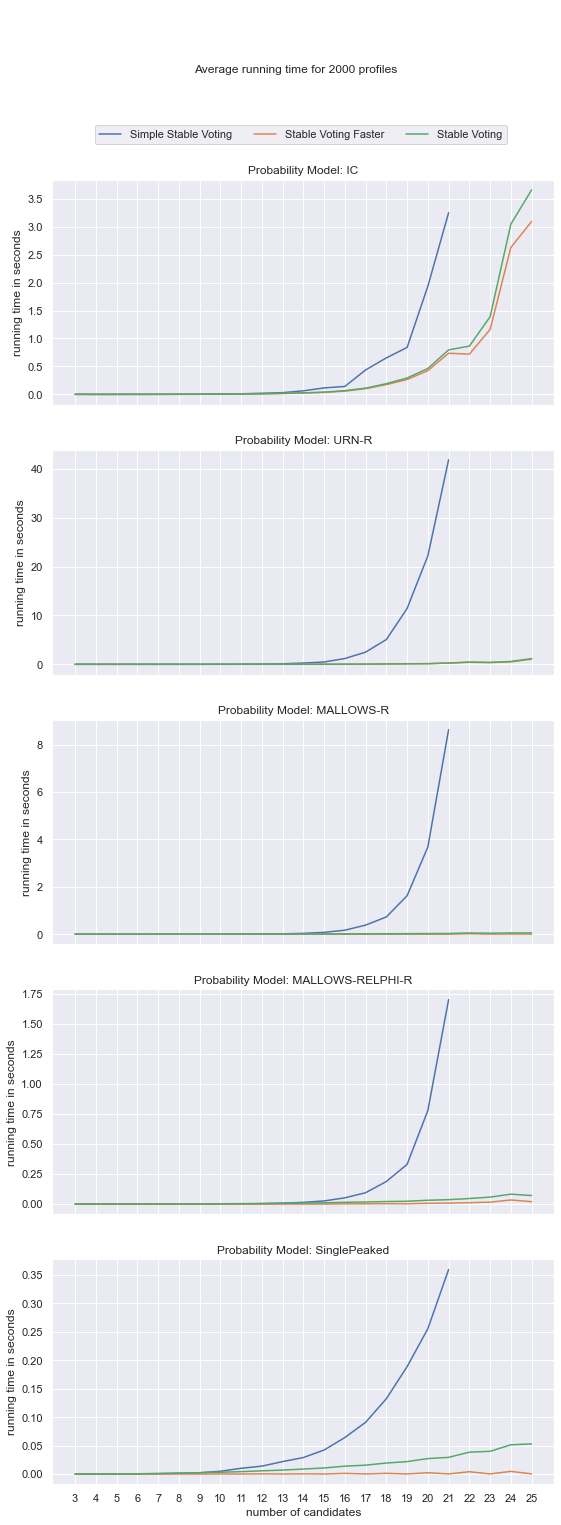

In [6]:
# running times for different probability models

pms = [
    'IC',
    'URN-R',
    'MALLOWS-R', 
    'MALLOWS-RELPHI-R', 
    'SinglePeaked'
]

fig, axs = plt.subplots(nrows=len(pms), sharex=True, figsize=(9,24))

for idx, pm in enumerate(pms): 
    ax = axs[idx]
    sns.lineplot(x="num_cands", y = "simple_sv_avg_running_time", data =df[df["pm"] == pm], ax=ax, label="Simple Stable Voting")
    sns.lineplot(x="num_cands", y = "sv_faster_avg_running_time", data =df[df["pm"] == pm], ax =ax, label="Stable Voting Faster")
    sns.lineplot(x="num_cands", y = "sv_avg_running_time", data =df[df["pm"] == pm], ax =ax, label="Stable Voting")
    ax.set_ylabel("running time in seconds")
    ax.set_xlabel("number of candidates")
    ax.set_title(f"Probability Model: {pm}")
    ax.legend().set_visible(False)
    
plt.suptitle("\n\n\n\n\nAverage running time for 2000 profiles")
plt.legend(ncol=3,bbox_to_anchor=(0.495, 6), loc='center',
                    borderaxespad=0.25)
plt.show()
#plt.savefig(f"{pm}_avg_running_times.pdf")
    


In [7]:
# data for producing boxen plots of the running times
if SKIP_TEST:
    df_all_running_times = pd.read_csv("./data/python_running_times_all_times.csv")
df_all_running_times["num_cands"] = df_all_running_times["num_cands"].astype(str)

df_all_running_times

,num_cands,pm,sv_running_time,simple_sv_running_time,sv_faster_running_time
0,3,IC,0.090433,0.000090,0.000016
1,3,IC,0.000161,0.000080,0.000010
2,3,IC,0.000130,0.000050,0.000014
3,3,IC,0.000124,0.000050,0.000007
4,3,IC,0.000123,0.000049,0.000013
...,...,...,...,...,...
229995,25,SinglePeaked,0.025198,NaN,0.000156
229996,25,SinglePeaked,0.051496,NaN,0.000330
229997,25,SinglePeaked,0.024486,NaN,0.000155
229998,25,SinglePeaked,0.024271,NaN,0.000148


In [8]:
def show_graph(pm): 
    fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(15,5))
    sns.boxenplot(x="num_cands", y="sv_running_time", data=df_all_running_times[df_all_running_times["pm"] == pm], ax=axs[0])
    sns.boxenplot(x="num_cands", y="simple_sv_running_time", data=df_all_running_times[df_all_running_times["pm"] == pm],  ax=axs[1])
    axs[0].set_ylabel('Running time in seconds')
    axs[1].set_ylabel('')
    axs[0].set_xlabel('Number of candidates')
    axs[1].set_xlabel('Number of candidates')
    axs[0].set_title(" Stable Voting running times")
    axs[1].set_title("Simple Stable Voting running times")
    plt.subplots_adjust(wspace=0.05)
    plt.suptitle(f"Probability model: {pm}")
    plt.show()
    #plt.savefig(f"{pm}_running_times.pdf")


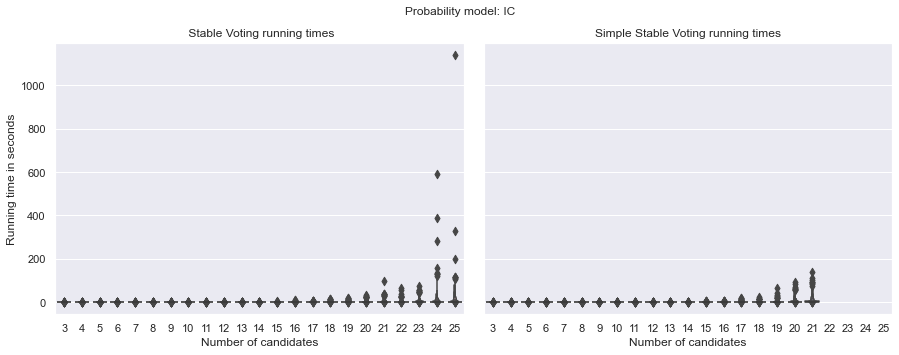

In [9]:
show_graph("IC")

In [ ]:
show_graph("URN-R")

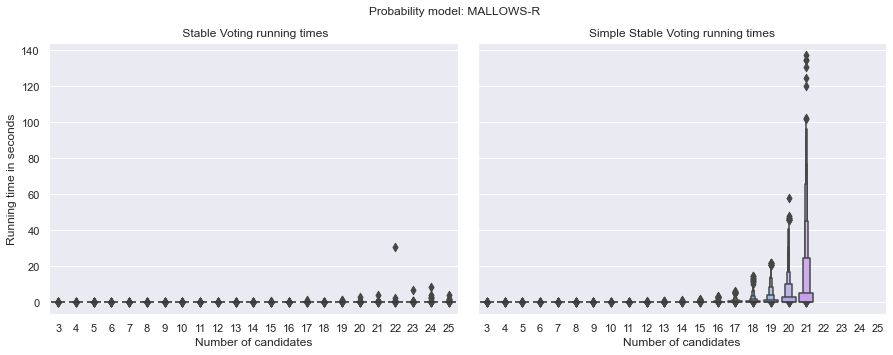

In [10]:
show_graph("MALLOWS-R")

In [ ]:
show_graph("MALLOWS-RELPHI-R")

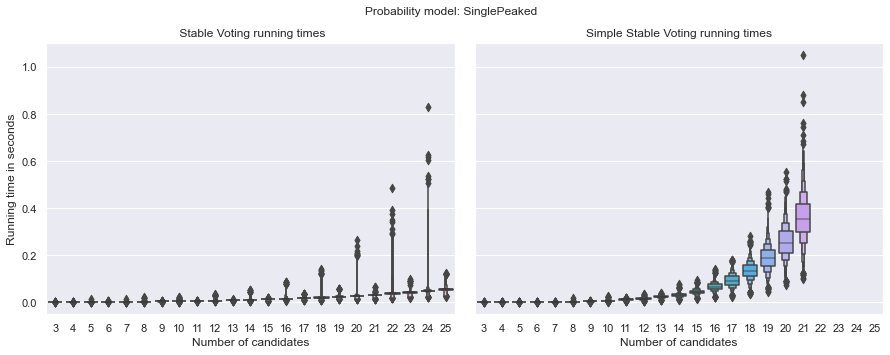

In [11]:
show_graph("SinglePeaked")